In [4]:
import pandas as pd
import numpy as np

import glob

import seaborn as sns
sns.reset_orig()

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'hot_r'

from scipy.optimize import curve_fit

from matplotlib.colors import LogNorm

%matplotlib inline

In [5]:
from scipy.stats import norm

def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [6]:
def tw_func(x, a, b, c, d):
    return a*x + b + c / (x - d)

In [7]:
def get_points(plot):
    
    x = np.array([plot.get_lines()[i].get_xdata()[0] for i in range(len(plot.get_lines()))])
    y1 = np.array([plot.get_lines()[i].get_ydata()[0] for i in range(len(plot.get_lines()))])
    y2 = np.array([plot.get_lines()[i].get_ydata()[1] for i in range(len(plot.get_lines()))])

    y = (y1+y2)/2
    yerr = (y2-y1)/2

    return x,y,yerr

In [8]:
#fname = '/tmp/alobanov/TOA_calib_part.h5'
#fname = '/tmp/alobanov/TOA_calib_full.h5'
#fname = '/Users/artur/cernbox/SWAN_projects/CERNTB/TOA/TOA_calib_full.h5'
fname = './TOA_calib_full_new2.h5'

In [9]:
columns = [u'rechit_chip_id', u'rechit_channel', u'rechit_energy', u'rechit_chan_id',
           u'rechit_toaRise_norm', u'rechit_toaFall_norm','rechit_amplitudeLow',
           u'toa_rise_time', u'tw_corr', u'toa_rise_calib']

In [10]:
%%time

df = pd.read_hdf(fname, columns = columns, key='/table')

CPU times: user 6.08 s, sys: 4.82 s, total: 10.9 s
Wall time: 15.7 s


In [11]:
df['rechit_layer'] = df.rechit_chip_id // 4

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 12059236 entries, 235000002.0 to 399050047.0
Data columns (total 11 columns):
rechit_chip_id         uint32
rechit_channel         uint32
rechit_energy          float32
rechit_chan_id         uint32
rechit_toaRise_norm    float64
rechit_toaFall_norm    float64
rechit_amplitudeLow    float32
toa_rise_time          float64
tw_corr                float64
toa_rise_calib         float64
rechit_layer           uint32
dtypes: float32(2), float64(5), uint32(4)
memory usage: 828.0 MB


In [13]:
#### HACK
df.toa_rise_time = df.toa_rise_calib

### Time layer

In [14]:
%%time
#tref_fname = './time_layer_test.h5'
#tref_fname = 'timeref/time_layer_test_runs_240_263.h5'
#tref_fname = 'timeref/time_layer_test_runs_310_350.h5'
tref_fname = 'timeref/test.h5'
df_tref = pd.read_hdf(tref_fname, key='/table')

CPU times: user 3.51 s, sys: 2.42 s, total: 5.93 s
Wall time: 6.94 s


In [15]:
#### HACK
df_tref.toa_rise_time = 25 - df_tref.toa_rise_time

In [16]:
df_tref.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8607465 entries, 310000001.0 to 399050047.0
Data columns (total 16 columns):
rechit_chip_id         int32
rechit_channel         int32
rechit_energy          float32
rechit_Tot             int16
rechit_amplitudeLow    float32
rechit_timeMaxLG       float32
rechit_toaRise         int16
rechit_toaFall         int16
run                    int64
loc_event              int64
rechit_chan_id         int32
rechit_layer           int32
rechit_toaRise_norm    float64
rechit_toaFall_norm    float64
toa_rise_time          float64
toa_fall_time          float64
dtypes: float32(3), float64(4), int16(3), int32(4), int64(2)
memory usage: 738.8 MB


## Load Si channels

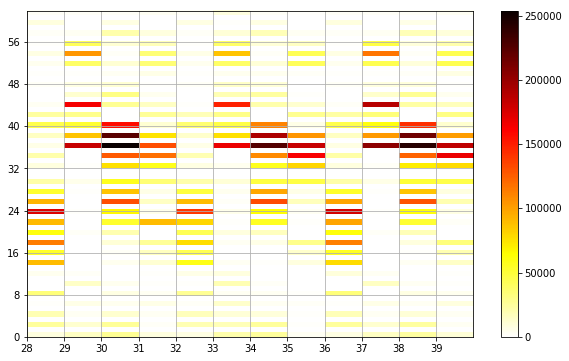

In [17]:
fig = plt.figure(figsize = (10,6))

min_chip = df.rechit_chip_id.min()
max_chip = df.rechit_chip_id.max()

plt.hist2d(df.rechit_chip_id,df.rechit_channel, bins = (range(min_chip,max_chip+2),64))

plt.xticks(range(min_chip,max_chip+1))
plt.yticks(range(0,64,8))

plt.grid()
plt.colorbar()
plt.show()

In [18]:
%%time
# layer = 9
# chip1 = 4*layer + 1
# chan1 = 36

# layer = 8
# chip2 = 4*layer + 2
# chan2 = 36

layer = 9
chip1 = 4*layer + 2
chan1 = 36

layer = 9
chip2 = 4*layer + 2
chan2 = 38

sel = df.rechit_energy > 20
sel &= df.toa_rise_time > 0
sel &= df.rechit_chip_id == chip1
df_ch1 = df[sel & (df.rechit_channel == chan1)].copy()

sel = df.rechit_energy > 20
sel &= df.toa_rise_time > 0
sel &= df.rechit_chip_id == chip2
df_ch2 = df[sel & (df.rechit_channel == chan2)].copy()

df_join = df_ch1.join(df_ch2, lsuffix='_ch1', rsuffix='_ch2')

# sel = (df_join.rechit_energy_ch1 > 0) & (df_join.rechit_energy_ch2 > 0)
# df_join = df_join[sel]
#df_join.dropna(inplace = True)

print len(df_join), ' entries'

242055  entries
CPU times: user 1.13 s, sys: 3.58 s, total: 4.7 s
Wall time: 8.71 s


In [19]:
## Timing reference layer

ref_layer = 29

ref_chip1 = 4*ref_layer + 2
ref_chan1 = 38

ref_chip2 = 4*ref_layer + 3
ref_chan2 = 38

sel = df_tref.toa_rise_time > 0
sel &= df_tref.rechit_chip_id == ref_chip1
#sel &= df_tref.rechit_Tot > 500
#sel &= df_tref.run < 294

df_tref_ch1 = df_tref[sel & (df_tref.rechit_channel == ref_chan1)].copy()

sel = df_tref.toa_rise_time > 0
sel &= df_tref.rechit_chip_id == ref_chip2
#sel &= df_tref.rechit_Tot > 500
#sel &= df_tref.run < 294

df_tref_ch2 = df_tref[sel & (df_tref.rechit_channel == ref_chan2)].copy()

df_tref_join = df_tref_ch1.join(df_tref_ch2, lsuffix='_ch1', rsuffix='_ch2')

# df_tref_join.dropna(inplace = True)
# df_tot_join =  df_tot_join[df_tot_join.run < 293]

print len(df_tref_join), ' entries'

1075926  entries


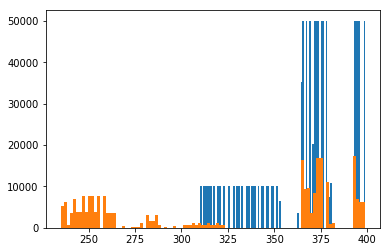

In [20]:
plt.hist(df_tref_join.run_ch1, 100)
plt.hist(df_join.index//1e6, 100)

plt.show()

In [21]:
df_tot_join = df_join.join(df_tref_join, lsuffix='_si', rsuffix='_ref')

In [42]:
from scipy.stats import iqr

In [53]:
def my_iqr(vals):
    
    q1 = np.nanpercentile(vals,0.25)
    q3 = np.nanpercentile(vals,0.75)
    
    return (q3-q1)/2.

In [54]:
def get_profile(x, y, bins = 100, xvars = ['mean'], yvars = ['mean']):
        
    df_p = pd.DataFrame([x,y]).T
    xvar = df_p.columns[0]
    yvar = df_p.columns[1]

    # create bin indexes
    bin_indx = np.digitize(df_p[xvar], bins=bins)
    # grouby bin, so we can calculate stuff
    binned = df_p.groupby(bin_indx)
    
    xvals = binned[xvar].agg(xvars)
    yvals = binned[yvar].agg(yvars)
    
    return xvals, yvals

In [55]:
dt = (df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2)

sel = dt > -5
sel &= dt < 15
sel &= abs(df_join.rechit_energy_ch2-200) < 50

y = dt[sel]

#bins = np.logspace(np.log10(25),np.log10(500),50)
#bins = np.linspace(20, 500, 50)
#x = df_join.rechit_energy_ch1[sel]

bins = np.logspace(np.log10(20),np.log10(2000),100)
#bins = np.linspace(20, 2500, 100)
x = df_join.rechit_amplitudeLow_ch1[sel]

In [139]:
t1 = df_tot_join.toa_rise_time_ch1_si
t2 = df_tot_join.toa_rise_time_ch1_ref

dt = (t1 - t2) #+ 2#%25 -7.3 #- mean_offset#*2

sel = dt > -5
sel &= dt < 15

y = dt[sel]

bins = np.logspace(np.log10(20),np.log10(2000),100)
x = df_tot_join.rechit_amplitudeLow_ch1_si[sel]

In [196]:
%%time
types = ['mean','median', 'std', iqr] #'sem', 

xvals,yvals = get_profile(x, y, bins, types,  types)
# xmean = xvals['mean']; ymean = yvals['mean']
# xmedian = xvals['median']; ymedian = yvals['median']
# xstd = xvals['std']; ystd = yvals['std']

CPU times: user 1.33 s, sys: 27.6 ms, total: 1.36 s
Wall time: 1.36 s


In [138]:
from scipy.stats import binned_statistic

In [200]:
%%timeit
xvals,yvals = get_profile(x, y, bins)

1 loop, best of 3: 1.12 s per loop


In [201]:
%%timeit
y_iqr = binned_statistic(x, y, bins=bins, statistic='mean').statistic

100 loops, best of 3: 15 ms per loop


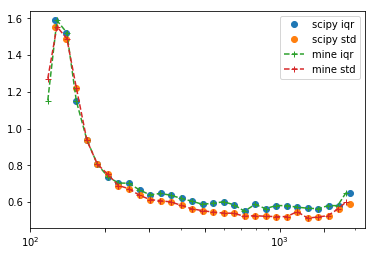

In [195]:
bins = np.logspace(np.log10(120),np.log10(2000),30)
bin_centers = (bins[:-1] + bins[1:])/2.

y_iqr = binned_statistic(x, y, bins=bins, statistic=iqr).statistic
plt.plot(bin_centers, y_iqr/1.35, 'o', label = 'scipy iqr')

y_std = binned_statistic(x, y, bins=bins, statistic='std').statistic
plt.plot(bin_centers, y_std, 'o', label = 'scipy std')


types = ['mean','median', 'std', iqr]
xvals,yvals = get_profile(x, y, bins, types,  types)
plt.plot(xvals['mean'],yvals['iqr']/1.35, '+--', label = 'mine iqr')
plt.plot(xvals['mean'],yvals['std'], '+--', label = 'mine std')


#plt.xlim(100,500)

plt.xscale('log')
plt.xticks([100,200,300,500,1000,1500])

plt.legend()

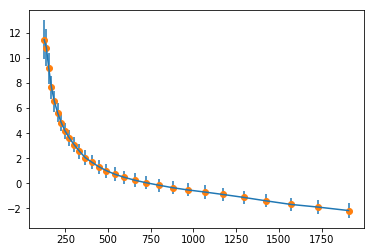

In [208]:
bins = np.logspace(np.log10(120),np.log10(2000),30)
bin_centers = (bins[:-1] + bins[1:])/2.

y_mean = binned_statistic(x, y, bins=bins, statistic='mean').statistic
y_std = binned_statistic(x, y, bins=bins, statistic='std').statistic

plt.errorbar(bin_centers, y_mean, y_std)
plt.plot(bin_centers, y_mean, 'o')

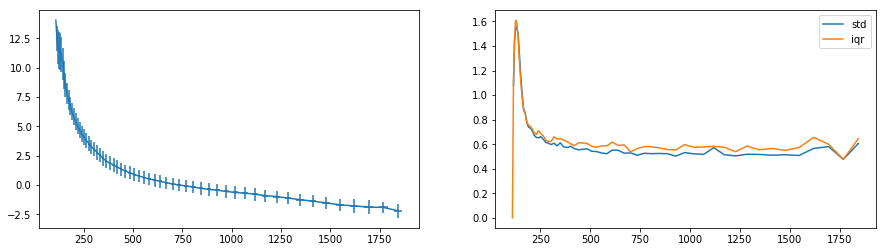

In [124]:
plt.figure(figsize = (15,4))

plt.subplot(121)
plt.errorbar(xvals['mean'],yvals['mean'],yvals['std'],xvals['std'])

plt.subplot(122)

plt.plot(xvals['mean'],yvals['std'], label = 'std')
#plt.plot(xvals['mean'],yvals['sem'], label = 'sem')
plt.plot(xvals['mean'],yvals['iqr']/1.349, label = 'iqr')
#plt.plot(xvals['mean'],yvals['my_iqr'], label = 'my_iqr')

plt.legend()
#plt.ylim(0,0.4)

[-6.14074778e-04 -1.50853678e+00  1.34021160e+03  2.40606999e+01]
[-3.43079899e-03  2.14838449e+00  4.15272137e+02  9.94409553e+01]


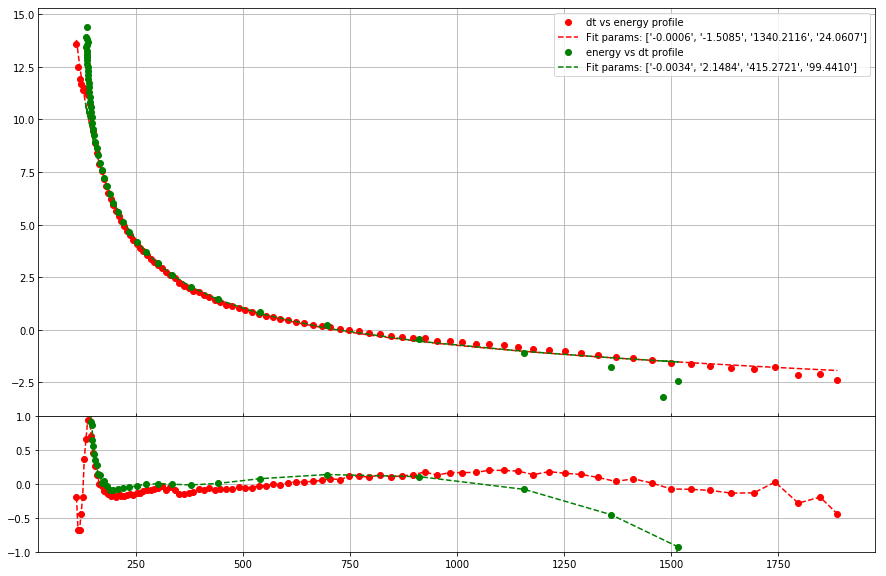

In [137]:
f, axs = plt.subplots(2, sharex=True, figsize = (15,10), gridspec_kw = {'height_ratios':[3,1]})

#bins = np.linspace(20,2000,100)
bins = np.logspace(np.log10(100),np.log10(2000),100)
xvals,yvals = get_profile(x, y, bins, types,  types)
axs[0].plot(xvals['mean'],yvals['mean'], 'ro', label = 'dt vs energy profile')

tw_params1, pcov = curve_fit(tw_func, xvals['mean'],yvals['mean'],
                                #sigma = x[sel]**-2,
                                p0 = [ -5.82e-03, -1.35e+00,  9.8e+03,  1.5e+01],
                                bounds=([-1,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

axs[0].plot(xvals['mean'],tw_func(xvals['mean'],*tw_params1), 'r--',
            label = 'Fit params: ' + str(["{0:0.4f}".format(p) for p in tw_params1]))
## plot difference
axs[1].plot(xvals['mean'],yvals['mean'] - tw_func(xvals['mean'],*tw_params1), 'ro--')

#bins = np.linspace(-5,15,100)
bins = 17 - np.logspace(np.log10(3),np.log10(20),50)

offset = 5 # hack to make dt positive
xvals,yvals = get_profile(y,x, bins, types,  types)
yvals['mean']

axs[0].plot(yvals['mean'],xvals['mean'], 'go', label = 'energy vs dt profile')

tw_params2, pcov = curve_fit(tw_func, yvals['mean'],xvals['mean'],
                                #sigma = x[sel]**-2,
                                p0 = [ -5.82e-03, -1.35e+00,  9.8e+03,  1.5e+01],
                                bounds=([-1,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

axs[0].plot(yvals['mean'],tw_func(yvals['mean'],*tw_params1), 'g--',
            label = 'Fit params: ' + str(["{0:0.4f}".format(p) for p in tw_params2]))
## plot difference
axs[1].plot(yvals['mean'],xvals['mean'] - tw_func(yvals['mean'],*tw_params1), 'go--')

print tw_params1
print tw_params2

f.subplots_adjust(hspace=0)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=True)

axs[0].grid()
axs[0].legend()
axs[0].tick_params(direction = 'in')

axs[1].set_ylim(-1,1)
axs[1].grid()

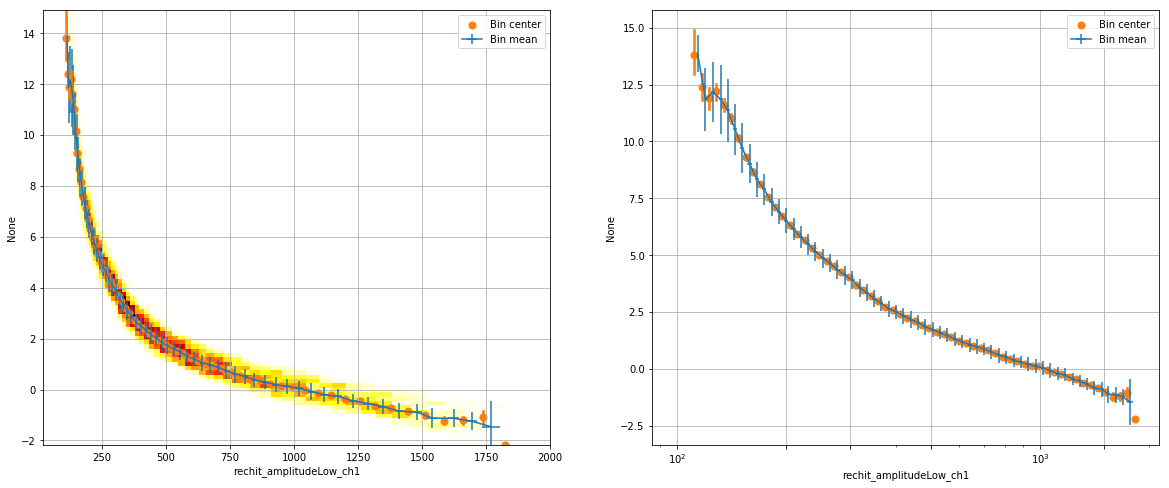

CPU times: user 2.97 s, sys: 694 ms, total: 3.67 s
Wall time: 3.7 s


In [298]:
%%time

plt.figure(figsize = (20,8))

plt.subplot(121)

plt.hist2d(x,y, (bins,100))

#plt.plot(xmean,ymean, 'o--', label = 'Bin mean')
plt.errorbar(xmean,ymean,ystd,xstd, label = 'Bin mean')

#plt.plot(xmedian,ymedian, 'o--', label = 'Bin median')
p = sns.regplot(x,y, x_bins = bins, fit_reg = False, label = 'Bin center')

plt.legend()
plt.grid()

plt.subplot(122)

#plt.plot(xmean,ymean, 'o--', label = 'Bin mean')
plt.errorbar(xmean,ymean,ystd,xstd, label = 'Bin mean')
#plt.plot(xmedian,ymedian, 'o--', label = 'Bin median')
p = sns.regplot(x,y, x_bins = bins, fit_reg = False, label = 'Bin center')

#plt.xlim(20,50)

plt.xscale('log')
plt.xticks([100,200,300,500,1000,1500])


plt.grid()
plt.legend()

plt.show()

In [228]:
plt.errorbar(xmean,ymean,ystd,xstd)
plt.errorbar(xmedian,ymedian,ystd,xstd)

<Container object of 3 artists>

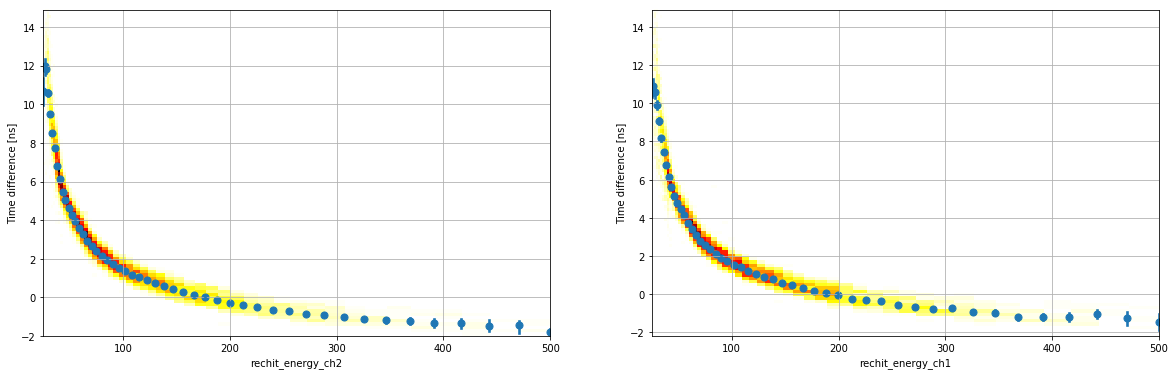

CPU times: user 2.76 s, sys: 825 ms, total: 3.59 s
Wall time: 3.87 s


In [19]:
%%time

fig = plt.figure(figsize = (20,6))

offset = 0#-0.7

dt = df_join.toa_rise_time_ch2 - df_join.toa_rise_time_ch1 + offset

bins = np.logspace(np.log10(25),np.log10(500),50)

plt.subplot(121)

sel = dt > -5
sel &= dt < 15
sel &= abs(df_join.rechit_energy_ch1-200) < 50

x = df_join.rechit_energy_ch2[sel]
y = dt[sel]

plt.hist2d(x,y,(bins,100))
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()

plt.subplot(122)

dt = (df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2) - offset

sel = dt > -5
sel &= dt < 15
sel &= abs(df_join.rechit_energy_ch2-200) < 50

x = df_join.rechit_energy_ch1[sel]
y = dt[sel]

plt.hist2d(x,y,(bins,100))
p2 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()
plt.show()

In [204]:
# ## Real silicon channel
# layer = 9

# chip1 = 4*layer + 2
# chan1 = 36

# sel = df.toa_rise_time > 0
# sel &= df.rechit_chip_id == chip1

# df_ch1 = df[sel & (df.rechit_channel == chan1)].copy()

# ## Timing reference channel
# layer = 29

# chip2 = 4*layer + 2
# chan2 = 38

# sel = df_tref.toa_rise_time > 0
# sel &= df_tref.rechit_chip_id == chip2

# #sel &= df_tref.rechit_Tot > 500
# #sel &= df_tref.run < 294

# df_ch2 = df_tref[sel & (df_tref.rechit_channel == chan2)].copy()

# df_tot_join = df_ch1.join(df_ch2, lsuffix='_si', rsuffix='_ref')

# df_tot_join.dropna(inplace = True)

# print len(df_tot_join), ' entries'

In [205]:
#df_tot_join =  df_tot_join[df_tot_join.run < 293]

In [206]:
## timing reference layer

In [250]:
#df_tot_join.dropna(inplace=True)

In [251]:
len(df_tot_join)

242055

In [212]:
df_tot_join.filter(regex = 'toa').columns

Index([u'rechit_toaRise_norm_ch1_si', u'rechit_toaFall_norm_ch1_si',
       u'toa_rise_time_ch1_si', u'toa_rise_calib_ch1',
       u'rechit_toaRise_norm_ch2_si', u'rechit_toaFall_norm_ch2_si',
       u'toa_rise_time_ch2_si', u'toa_rise_calib_ch2', u'rechit_toaRise_ch1',
       u'rechit_toaFall_ch1', u'rechit_toaRise_norm_ch1_ref',
       u'rechit_toaFall_norm_ch1_ref', u'toa_rise_time_ch1_ref',
       u'toa_fall_time_ch1', u'rechit_toaRise_ch2', u'rechit_toaFall_ch2',
       u'rechit_toaRise_norm_ch2_ref', u'rechit_toaFall_norm_ch2_ref',
       u'toa_rise_time_ch2_ref', u'toa_fall_time_ch2'],
      dtype='object')

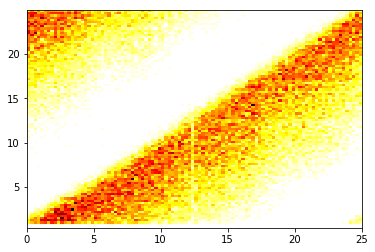

In [252]:
sel = df_tot_join.toa_rise_time_ch1_ref > 0
sel &= df_tot_join.rechit_energy_ch2_si > 100

t1 = df_tot_join.toa_rise_time_ch2_si
t2 = df_tot_join.toa_rise_time_ch2_ref

dt = (t1 - t2)#%25

sel = abs(dt) < 25

#plt.hist(df_tot_join.rechit_energy_ch1_si[sel], 100)
plt.hist2d(t1[sel],t2[sel],100)
#plt.hist(dt[sel], 100)

plt.show()

In [253]:
df_tot_join.filter(regex='run').columns

Index([u'run_ch1', u'run_ch2'], dtype='object')

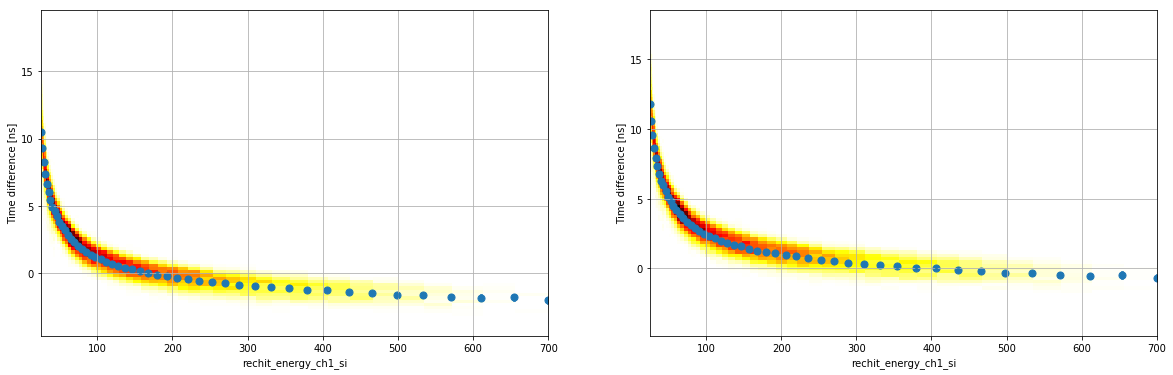

In [215]:
fig = plt.figure(figsize = (20,6))

bins = np.logspace(np.log10(25),np.log10(700),50)


plt.subplot(121)

t1 = df_tot_join.toa_rise_time_ch1_si
t2 = df_tot_join.toa_rise_time_ch1_ref

dt = (t1 - t2)#%25

sel = dt > -5
sel &= dt < 20

x = df_tot_join.rechit_energy_ch1_si[sel]
y = dt[sel]


plt.hist2d(x,y,(bins,100))
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()

plt.subplot(122)

t1 = df_tot_join.toa_rise_time_ch1_si
t2 = df_tot_join.toa_rise_time_ch2_ref

dt = (t1 - t2)#%25

sel = dt > -5
sel &= dt < 20

x = df_tot_join.rechit_energy_ch1_si[sel]
y = dt[sel]


plt.hist2d(x,y,(bins,100))
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()

In [216]:
sel = df_tot_join.rechit_amplitudeLow_ch1_si < 200
(df_tot_join.rechit_amplitudeLow_ch1_si[sel]/df_tot_join.rechit_energy_ch1_si[sel]).mean()

5.254848

In [217]:
plt.figure(figsize = (10,8))

#bins = np.logspace(np.log10(25),np.log10(300),50)
bins = np.linspace(100,2500,100)

t1 = df_tot_join.toa_rise_time_ch1_si
t2 = df_tot_join.toa_rise_time_ch2_ref

dt = (t1 - t2)#%25

sel = dt > -5
sel &= dt < 20

#x = df_tot_join.rechit_energy_ch1_si[sel]
x = df_tot_join.rechit_amplitudeLow_ch1_si[sel]
#x = df_tot_join.rechit_Tot1_si[sel]
y = dt[sel]
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False, label = 'LG')

x = df_tot_join.rechit_energy_ch1_si[sel] * 4.963025
y = dt[sel]

p2 = sns.regplot(x,y, x_bins = bins, fit_reg= False, label = 'Energy * 5')

plt.grid()
plt.legend()

In [268]:
plt.figure(figsize = (10,8))

bins = np.logspace(np.log10(100),np.log10(2500),50)
#bins = np.linspace(100,2500,100)

t1 = df_tot_join.toa_rise_time_ch1_si
t2 = df_tot_join.toa_rise_time_ch2_ref

dt = (t1 - t2)#%25

sel = dt > -5
sel &= dt < 20

#x = df_tot_join.rechit_energy_ch1_si[sel]
x = df_tot_join.rechit_amplitudeLow_ch1_si[sel] / 5.
#x = df_tot_join.rechit_Tot1_si[sel]
y = dt[sel]
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False, label = 'LG / 5')

x = df_tot_join.rechit_energy_ch1_si[sel]# * 4.963025
y = dt[sel]

p2 = sns.regplot(x,y, x_bins = bins, fit_reg= False, label = 'Energy')

plt.xscale('log')
plt.grid()
plt.legend()

In [219]:
#dt = df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2
t1 = df_tot_join.toa_rise_time_ch1_si
t2 = df_tot_join.toa_rise_time_ch1_ref

dt = (t1 - t2)%25 - offset

sel = abs(dt) < 10
mean_offset = dt[sel].mean()/2.

In [220]:
mean_offset

2.0568041961884487

In [221]:
sel = df_join.rechit_energy_ch2 > 200
sel &= df_join.rechit_energy_ch2 < 800

plt.hist(df_join.rechit_energy_ch2[sel],100)

sel = df_tot_join.rechit_energy_ch1_si > 200
sel &= df_tot_join.rechit_energy_ch1_si < 800
plt.hist(df_tot_join.rechit_energy_ch1_si[sel],100, alpha = 0.8)


plt.yscale('log')

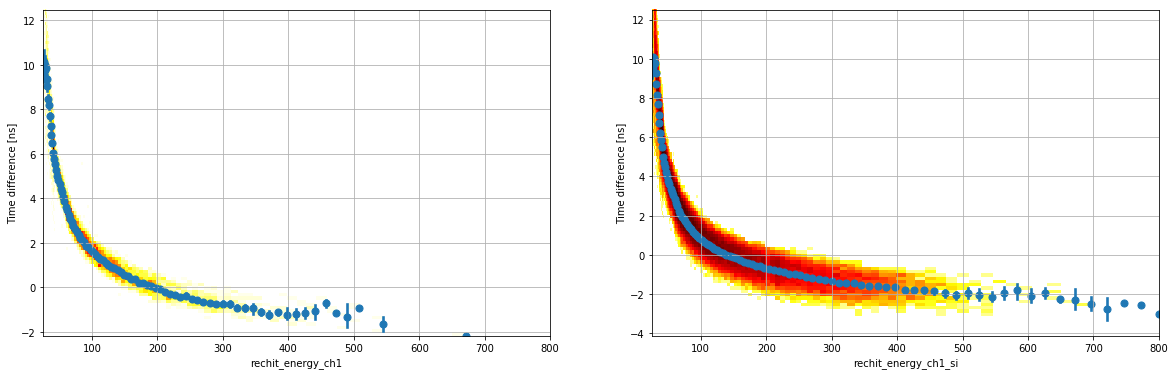

In [258]:
fig = plt.figure(figsize = (20,6))

bins = np.logspace(np.log10(25),np.log10(800),100)

plt.subplot(121)

dt = df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2 


sel = dt > -5
sel &= dt < 12.5
sel &= abs(df_join.rechit_energy_ch2-200) < 50

x = df_join.rechit_energy_ch1[sel]
y = dt[sel]

plt.hist2d(x,y,(bins,100))
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()

plt.subplot(122)

t1 = df_tot_join.toa_rise_time_ch1_si
t2 = df_tot_join.toa_rise_time_ch1_ref

dt = (t1 - t2) #+ 2#%25 -7.3 #- mean_offset#*2

sel = dt > -5
sel &= dt < 12.5

x = df_tot_join.rechit_energy_ch1_si[sel]
y = dt[sel]

plt.hist2d(x,y,(bins,100), norm = LogNorm())
p2 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()
plt.show()

[-3.32922940e-03 -6.70511468e-01  2.48158402e+02  5.41005421e+00]
[-2.95276225e-03 -1.12236945e+00  1.96756493e+02  1.17989529e+01]


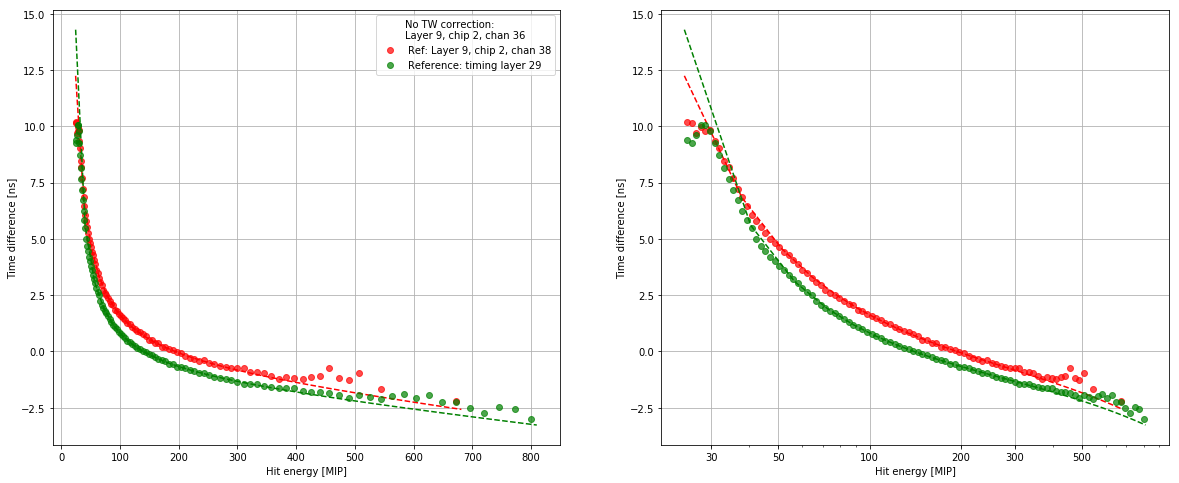

In [259]:
fig = plt.figure(figsize = (20,8))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for ax in [ax1,ax2]:
    x,y,yerr = get_points(p1)

    sel = x > 29
    sel &= x < 300

    tw_params1, pcov = curve_fit(tw_func, x[sel] , y[sel],
                                sigma = x[sel]**-2,
                                p0 = [ -5.82e-03, -1.35e+00,  9.8e+03,  1.5e+01],
                                bounds=([-1,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )
    

    xs = np.linspace(min(x)-.5,max(x)+10)
    label = 'Ref: Layer %i, chip %i, chan %i' %(chip2//4, chip2%4, chan2)
    ax.plot(x,y,'ro', label = label, alpha = 0.7)#, x,yerr)
    ax.plot(xs,tw_func(xs,*tw_params1), 'r--')


    x,y,yerr = get_points(p2)
    sel = x > 29
    sel &= x < 300

    tw_params2, pcov = curve_fit(tw_func, x[sel] , y[sel],
                                sigma = x[sel]**-2,
                                p0 = [ -5.82e-03, -1.35e+00,  9.8e+03,  1.5e+01],
                                bounds=([-1,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

    xs = np.linspace(min(x)-.5,max(x)+10)
    
    label = 'Reference: timing layer 29'
    ax.plot(x,y,'go', label = label, alpha = 0.7)#, x,yerr)
    ax.plot(xs,tw_func(xs,*tw_params2), 'g--')

    ax.set_ylabel('Time difference [ns]')
    ax.set_xlabel('Hit energy [MIP]')
    
print tw_params1
print tw_params2

leg = ax1.legend()

label = 'Layer %i, chip %i, chan %i' %(chip1//4, chip1%4, chan1)
leg.set_title('No TW correction: \n' + label)

ax1.grid()
ax2.grid()

ax2.set_xscale('log')
#ax2.set_xticks(x[::10])
ax2.set_xticks([30,50,100,200,300,500])
ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()

In [260]:
fig = plt.figure(figsize = (20,4))

x1,y1,yerr1 = get_points(p1)
x2,y2,yerr2 = get_points(p2)

indx1 = np.in1d(x1,x2)
indx2 = np.in1d(x2,x1)

plt.plot(x1[indx1], y1[indx1]-y2[indx2], 'o--')

plt.xlabel('Energy [MIP]')
#plt.ylim(-3,-1.5)

Text(0.5,0,u'Energy [MIP]')

Check both Si Channels and compare

In [261]:
fig = plt.figure(figsize = (20,6))

bins = np.logspace(np.log10(25),np.log10(800),100)

plt.subplot(121)

t1 = df_tot_join.toa_rise_time_ch1_si
t2 = df_tot_join.toa_rise_time_ch1_ref

dt = (t1 - t2) #%25 -7.3 #- mean_offset#*2

sel = dt > -5
sel &= dt < 20

x = df_tot_join.rechit_energy_ch1_si[sel]
y = dt[sel]

plt.hist2d(x,y,(bins,100), norm = LogNorm())
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()


plt.subplot(122)

t1 = df_tot_join.toa_rise_time_ch2_si
t2 = df_tot_join.toa_rise_time_ch1_ref

dt = (t1 - t2) #+ 1#%25 -7.3 #- mean_offset#*2

sel = dt > -5
sel &= dt < 20

x = df_tot_join.rechit_energy_ch2_si[sel]
y = dt[sel]

plt.hist2d(x,y,(bins,100), norm = LogNorm())
p2 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()
plt.show()

In [262]:
fig = plt.figure(figsize = (20,8))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for ax in [ax1,ax2]:
    x,y,yerr = get_points(p1)

    sel = x > 20
    sel &= x < 300

    tw_params1, pcov = curve_fit(tw_func, x[sel] , y[sel],
                                sigma = x[sel]**-1,
                                p0 = [ -5.82e-03, -1.35e+00,  9.8e+03,  1.5e+01],
                                bounds=([-1,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )
    

    xs = np.linspace(min(x)-.5,max(x)+10)
    label = 'Layer %i, chip %i, chan %i' %(chip1//4, chip1%4, chan1)
    ax.plot(x,y,'ro', label = label, alpha = 0.7)#,mfc='none')#, x,yerr)
    ax.plot(xs,tw_func(xs,*tw_params1), 'r--')


    x,y,yerr = get_points(p2)
    sel = x > 20
    sel &= x < 300

    tw_params2, pcov = curve_fit(tw_func, x[sel] , y[sel],
                                sigma = x[sel]**-1,
                                p0 = [ -5.82e-03, 0,  100,  10],
                                bounds=([-1,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

    xs = np.linspace(min(x)-.5,max(x)+10)
    
    label = 'Layer %i, chip %i, chan %i' %(chip2//4, chip2%4, chan2)
    ax.plot(x,y,'go', label = label, alpha = 0.7)#,mfc='none')#, x,yerr)
    ax.plot(xs,tw_func(xs,*tw_params2), 'g--')

    ax.set_ylabel('Time difference [ns]')
    ax.set_xlabel('Hit energy [MIP]')
    
print tw_params1
print tw_params2

leg = ax1.legend()
leg.set_title('No TW-corrected reference:')

ax1.grid()
ax2.grid()

ax2.set_xscale('log')
#ax2.set_xticks(x[::10])
ax2.set_xticks([30,50,100,200,300,500])
ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()

[-1.96064129e-03 -1.51627378e+00  2.35832469e+02  7.51123831e+00]
[-2.45162073e-03 -1.47938611e+00  2.28798010e+02  8.23985446e+00]


In [267]:
fig = plt.figure(figsize = (20,4))

x1,y1,yerr1 = get_points(p1)
x2,y2,yerr2 = get_points(p2)

indx1 = np.in1d(x1,x2)
indx2 = np.in1d(x2,x1)

plt.plot(x1[indx1], y1[indx1]-y2[indx2], 'o--')

plt.xlabel('Energy [MIP]')
#plt.ylim(-3,-1.5)
#plt.ylim(0,0.4)
#plt.xlim(50,400)

Text(0.5,0,u'Energy [MIP]')

## Apply TW correction

In [228]:
tw_params1 = tw_params1.tolist()
tw_params2 = tw_params2.tolist()

In [229]:
%%time
df['tw_corr'] = 0

thr = 4000

sel = df_join.rechit_energy_ch1 < thr
thr_tw1 = tw_func(thr,*tw_params2)
df_join['tw_corr_ch1'] = df_join['rechit_energy_ch1'].apply(lambda x: tw_func(x, *tw_params2) - thr_tw1)

sel = df_join.rechit_energy_ch2 < thr
thr_tw2 = tw_func(thr,*tw_params1)
df_join['tw_corr_ch2'] = df_join['rechit_energy_ch2'].apply(lambda x: tw_func(x, *tw_params1) - thr_tw1)

CPU times: user 271 ms, sys: 120 ms, total: 391 ms
Wall time: 555 ms


In [230]:
# df_join['tw_corr_ch1'] = df_join['rechit_energy_ch1'].apply(lambda x: tw_func(x, *tw_params2))
# df_join['tw_corr_ch2'] = df_join['rechit_energy_ch2'].apply(lambda x: tw_func(x, *tw_params1))

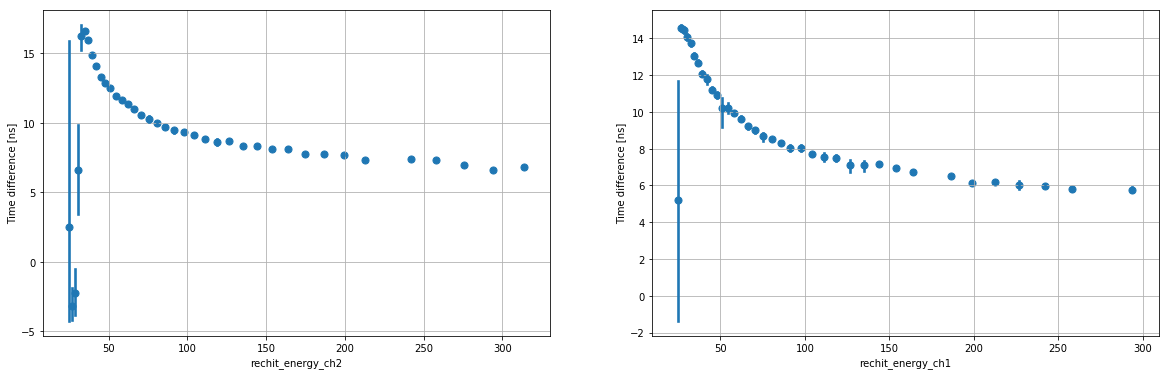

In [231]:
fig = plt.figure(figsize = (20,6))

offset = 0#-0.7

dt = df_join.toa_rise_time_ch2 - df_join.toa_rise_time_ch1 + offset + df_join.tw_corr_ch1

bins = np.logspace(np.log10(25),np.log10(600),50)

plt.subplot(121)

sel = dt > -5
sel &= dt < 18
sel &= abs(df_join.rechit_energy_ch1-200) < 50

x = df_join.rechit_energy_ch2[sel]
y = dt[sel]

#plt.hist2d(x,y,(bins,100))
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()

plt.subplot(122)

dt = (df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2) - offset + df_join.tw_corr_ch2

sel = dt > -5
sel &= dt < 15
sel &= abs(df_join.rechit_energy_ch2-200) < 50

x = df_join.rechit_energy_ch1[sel]
y = dt[sel]

#plt.hist2d(x,y,(bins,100))
p2 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()
plt.show()

[-1.94145328e-03  6.14274236e+00  3.81595951e+02 -1.16108996e+01]
[-1.94142696e-03  5.36075148e+00  2.68144797e+02 -1.05389961e-02]


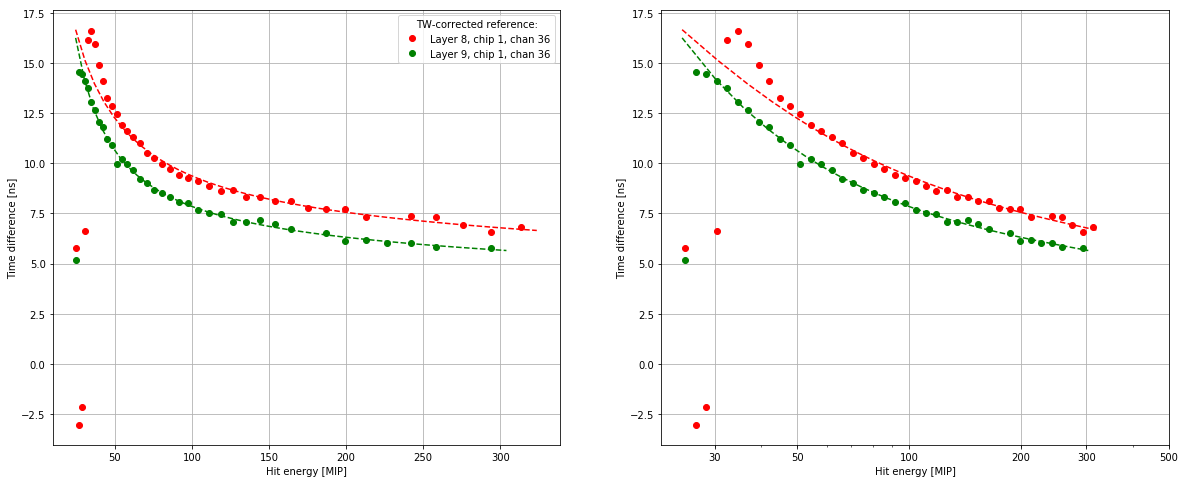

In [232]:
fig = plt.figure(figsize = (20,8))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for ax in [ax1,ax2]:
    x,y,yerr = get_points(p1)

    sel = x > 29
    sel &= x < 300

    tw_params1, pcov = curve_fit(tw_func, x[sel] , y[sel],
                                sigma = 1/x[sel],
                                p0 = [ -5.82e-03, -1.35e+00,  9.8e+03,  1.5e+01],
                                bounds=([-1,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )
    

    xs = np.linspace(min(x)-.5,max(x)+10)
    label = 'Layer %i, chip %i, chan %i' %(chip1//4, chip1%4, chan1)
    ax.plot(x,y,'ro', label = label)#, x,yerr)
    ax.plot(xs,tw_func(xs,*tw_params1), 'r--')


    x,y,yerr = get_points(p2)
    sel = x > 29
    sel &= x < 300

    tw_params2, pcov = curve_fit(tw_func, x[sel] , y[sel],
                                sigma = 1/x[sel],
                                p0 = [ -5.82e-03, -1.35e+00,  9.8e+03,  1.5e+01],
                                bounds=([-1,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

    xs = np.linspace(min(x)-.5,max(x)+10)
    
    label = 'Layer %i, chip %i, chan %i' %(chip2//4, chip2%4, chan2)
    ax.plot(x,y,'go', label = label)#, x,yerr)
    ax.plot(xs,tw_func(xs,*tw_params2), 'g--')

    ax.set_ylabel('Time difference [ns]')
    ax.set_xlabel('Hit energy [MIP]')
    
print tw_params1
print tw_params2

leg = ax1.legend()
leg.set_title('TW-corrected reference:')

ax1.grid()
ax2.grid()

ax2.set_xscale('log')
#ax2.set_xticks(x[::10])
ax2.set_xticks([30,50,100,200,300,500])
ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()

In [233]:
sel = x > 200
plt.plot(x[sel],y[sel], 'o')
plt.grid()

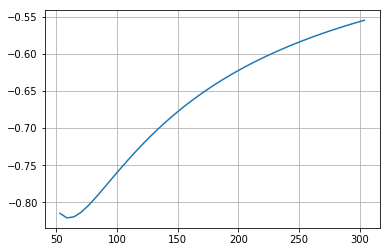

In [234]:
y_diff = tw_func(xs,*tw_params2) - tw_func(xs,*tw_params1)
y_diff /= 2 

sel = xs > 50
plt.plot(xs[sel],y_diff[sel])
plt.grid()

In [235]:
tw_params1 = tw_params1.tolist()
tw_params2 = tw_params2.tolist()

In [236]:
df['tw_corr'] = 0

thr = 400

sel = df_join.rechit_energy_ch1 < thr
thr_tw1 = tw_func(thr,*tw_params2)
df_join['tw_corr_ch1'] = df_join['rechit_energy_ch1'].apply(lambda x: tw_func(x, *tw_params2) - thr_tw1)

sel = df_join.rechit_energy_ch2 < thr
thr_tw2 = tw_func(thr,*tw_params1)
df_join['tw_corr_ch2'] = df_join['rechit_energy_ch2'].apply(lambda x: tw_func(x, *tw_params1) - thr_tw1)

In [237]:
# df_join['tw_corr_ch1'] = df_join['rechit_energy_ch1'].apply(lambda x: tw_func(x, *tw_params2))
# df_join['tw_corr_ch2'] = df_join['rechit_energy_ch2'].apply(lambda x: tw_func(x, *tw_params1))

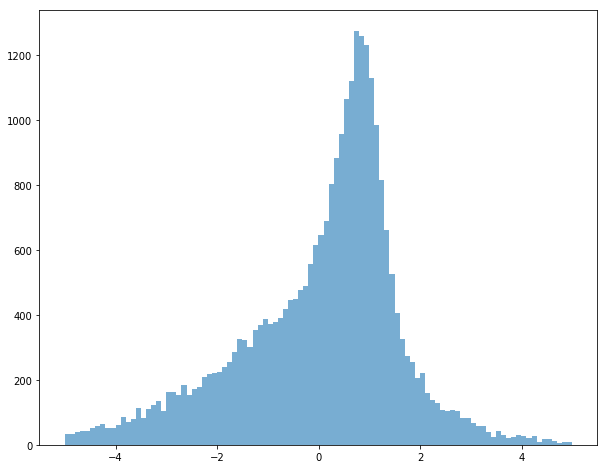

In [238]:
fig = plt.figure(figsize = (10,8))

# original w/o TW corr
#dt = df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2

dt = df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2
#- df_join.tw_corr_ch1
#- df_join.tw_corr_ch2

sel = abs(dt) < 5
#plt.hist(dt[sel],100)

dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1 - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)

sel = abs(dt) < 5
plt.hist(dt[sel],100, alpha = 0.6)
plt.show()

In [239]:
fig = plt.figure(figsize = (10,6))


dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1 - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)

#dt = df_join.toa_rise_time_ch1 - (df_join.toa_rise_time_ch2)

sel = abs(dt) < 3

dt_cent = 100
dt_w = 10

sel &= abs(df_join.rechit_energy_ch2-dt_cent) < dt_w
sel &= abs(df_join.rechit_energy_ch1-dt_cent) < dt_w

#sel &= df_join.rechit_energy_ch2 > 300
#sel &= abs(df_join.rechit_energy_ch1-200) < 20




bins = plt.hist(dt[sel],
                bins = np.linspace(dt[sel].mean()-0.85,dt[sel].mean()+0.85,50),
                density = True)
y = np.array(bins[0])
x = np.array(bins[1][1:])

sel1 = abs(x-dt[sel].mean()) < 1.5
x = x[sel1]
y = y[sel1]

popt, pcov = curve_fit(gauss_function, x, y, p0 = [1, x.mean(), x.std()])
plt.plot(x, gauss_function(x, *popt),
         label='Fit: C, mean, sigma\n'+str(["%.3f"%p for p in popt]))
print 'Gauss fit parameters are ', popt

plt.legend(loc = 'center right')
plt.xlabel('Time difference [ns]')

plt.show()

dt[sel].std()

Gauss fit parameters are  [1.85605684 1.08708536 0.20686525]


0.23155649145638715

In [240]:
fig = plt.figure(figsize = (10,8))

dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1
dt -= df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2

sel = abs(dt+1.5) < 0.5

sel &= abs(df_join.rechit_energy_ch1 - 150) < 50
sel &= df_join.rechit_energy_ch2 < 600
sel &= df_join.rechit_energy_ch2 > 30

x = df_join[sel].rechit_energy_ch2
y = dt[sel]

bins = np.logspace(np.log10(25),np.log10(600),50)

plt.hist2d(x,y,(bins,20))

p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.show()

In [241]:
x = np.array([p1.get_lines()[i].get_xdata()[0] for i in range(len(p1.get_lines()))])
y1 = np.array([p1.get_lines()[i].get_ydata()[0] for i in range(len(p1.get_lines()))])
y2 = np.array([p1.get_lines()[i].get_ydata()[1] for i in range(len(p1.get_lines()))])

y = (y1+y2)/2
yerr = (y2-y1)/2

x1 = x; y1 = y; yerr1 = yerr

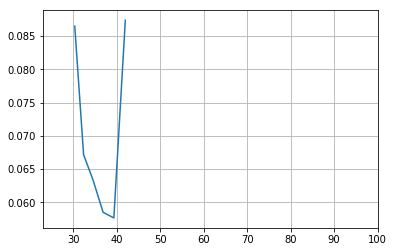

In [242]:
#plt.plot(x,y,'o')
plt.plot(x,yerr)
plt.xlim(23,100)
plt.grid()

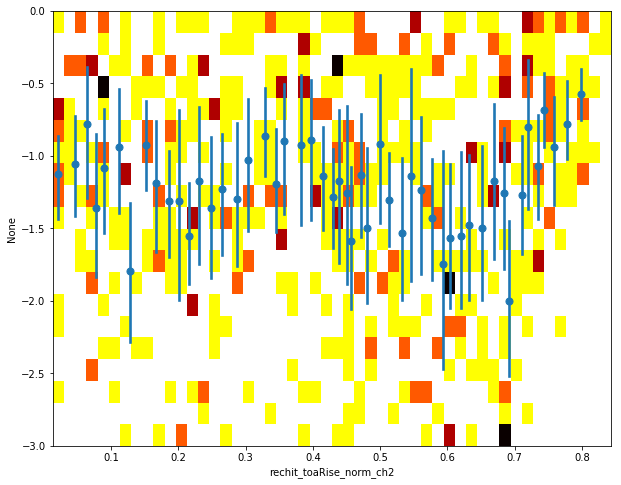

In [243]:
fig = plt.figure(figsize = (10,8))

dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1
dt -= df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2

sel = abs(dt+1.5) < 1.5

sel &= abs(df_join.rechit_energy_ch1 - 200) < 50
sel &= df_join.rechit_energy_ch2 < 200
sel &= df_join.rechit_energy_ch2 > 30

x = df_join[sel].rechit_toaRise_norm_ch2
y = dt[sel]

plt.hist2d(x,y,(50,20))

p1 = sns.regplot(x,y, x_bins = 50, fit_reg= False)

plt.show()

Gauss fit parameters are  [2.83452022 0.85041182 0.1407442 ]


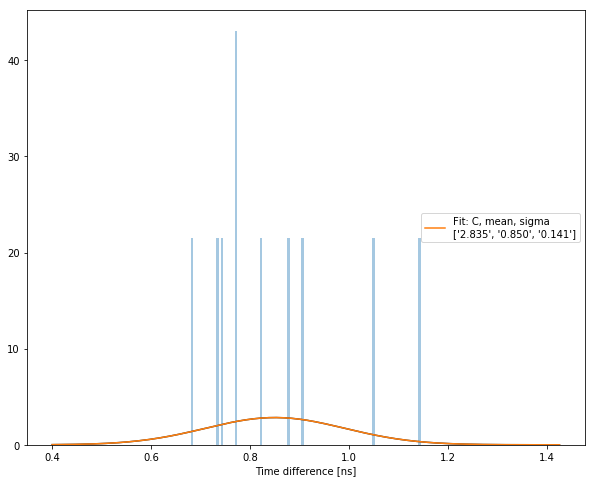

0.14835741297110028

In [244]:
fig = plt.figure(figsize = (10,8))

dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1
dt -= df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2

sel = abs(dt) < 2.75

# sel &= abs(df_join.rechit_toaRise_norm_ch1-0.3)<0.2
# sel &= abs(df_join.rechit_toaRise_norm_ch2-0.3)<0.2

sel &= df_join.rechit_energy_ch1 > 150
sel &= df_join.rechit_energy_ch2 > 200

# sel &= abs(df_join.rechit_energy_ch1-200) < 50
# sel &= abs(df_join.rechit_energy_ch2-200) < 50

x = df_join[sel].rechit_energy_ch2
y = dt[sel]

p = sns.distplot(y,
                 bins = 100,
                 fit=norm, kde=False)

x = p.get_lines()[0].get_xdata()
y = p.get_lines()[0].get_ydata()

popt, pcov = curve_fit(gauss_function, x, y, p0 = [1, x.mean(), x.std()])
plt.plot(x, gauss_function(x, *popt),
         label='Fit: C, mean, sigma\n'+str(["%.3f"%p for p in popt]))
print 'Gauss fit parameters are ', popt

plt.legend(loc = 'center right')
plt.xlabel('Time difference [ns]')

plt.show()

dt[sel].std()

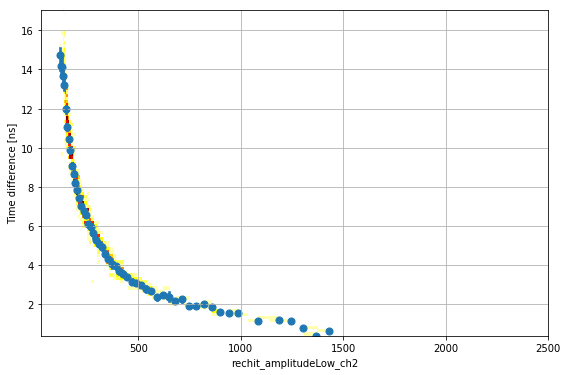

In [245]:
fig = plt.figure(figsize = (20,6))

offset = 0#-0.7

dt = df_join.toa_rise_time_ch2 - df_join.toa_rise_time_ch1 + offset + df_join.tw_corr_ch1

bins = np.logspace(np.log10(25),np.log10(2500),100)

plt.subplot(121)

sel = dt > 0
sel &= dt < 25
sel &= abs(df_join.rechit_energy_ch1-200) < 50

#x = df_join.rechit_energy_ch2[sel]
x = df_join.rechit_amplitudeLow_ch2[sel]
y = dt[sel]

plt.hist2d(x,y,(bins,100))
p1 = sns.regplot(x,y, x_bins = bins, fit_reg= False)

plt.ylabel('Time difference [ns]')
plt.grid()


In [246]:
df_join['rise_time_ch1'] =  df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1
df_join['rise_time_ch2'] =  df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2

ValueError: cannot convert float NaN to integer

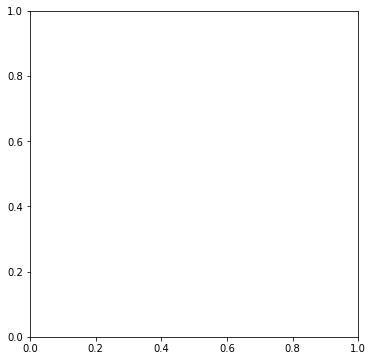

In [247]:
fig = plt.figure(figsize = (20,6))

plt.subplot(131)
plt.hist2d(df_join.rise_time_ch1,df_join.rise_time_ch2,100)

dt = df_join.rise_time_ch1 - df_join.rise_time_ch2

plt.subplot(132)
sel = abs(dt-dt.mean()) < 10
plt.hist(dt[sel],100)

plt.subplot(133)
sel = abs(dt-dt.mean()) < 1.5
plt.scatter(df_join[sel].rechit_energy_ch1,df_join[sel].rechit_energy_ch2,100, c = abs(dt[sel]-dt[sel].mean()), cmap = 'viridis')
plt.colorbar()
plt.show()